In [1]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.set(font_scale=1.5)
%matplotlib inline

In [2]:
def query_features():
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    
    with engine.connect() as conn:
        features = pd.read_sql(
        """
        SELECT 
            f.departure_was_delayed_15 as was_delayed,
            f.airport as departure_airport,
            f.departure_month as month,
            f.departure_date as date,
            f.departure_hod as hour_of_departure,
            f.carrier as carrier,
            f.distance as flight_distance,
            f.elapsed_time_scheduled as elapsed_time_scheduled,
            f.hourly_visibility as visibility,
            f.hourly_dry_bulb_temp_f as temperature_f,
            f.hourly_precipitation as precipitation,
            f.hourly_wind_speed as wind_speed,
            f.hourly_wind_gust_speed as gust_speed,
            f.hourly_station_pressure as station_pressure
        FROM 
            features AS f
        """, 
        conn)
    
    for col in ['carrier', 'departure_airport']:
        features = features.drop(col, axis=1)
        #features[col] = features[col].astype('category')
    
    return pd.get_dummies(features, drop_first=True)

# Get summary data for selected date range, counting flights delayed more than 15 minutes on departure
features = query_features()
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31065 entries, 0 to 31064
Data columns (total 12 columns):
was_delayed               31065 non-null int64
month                     31065 non-null int64
date                      31065 non-null int64
hour_of_departure         31065 non-null int64
flight_distance           31065 non-null int64
elapsed_time_scheduled    31065 non-null int64
visibility                31065 non-null float64
temperature_f             31065 non-null float64
precipitation             31065 non-null float64
wind_speed                31065 non-null float64
gust_speed                31065 non-null float64
station_pressure          31065 non-null float64
dtypes: float64(6), int64(6)
memory usage: 2.8 MB


# To what extent are there correlations in the existing features?

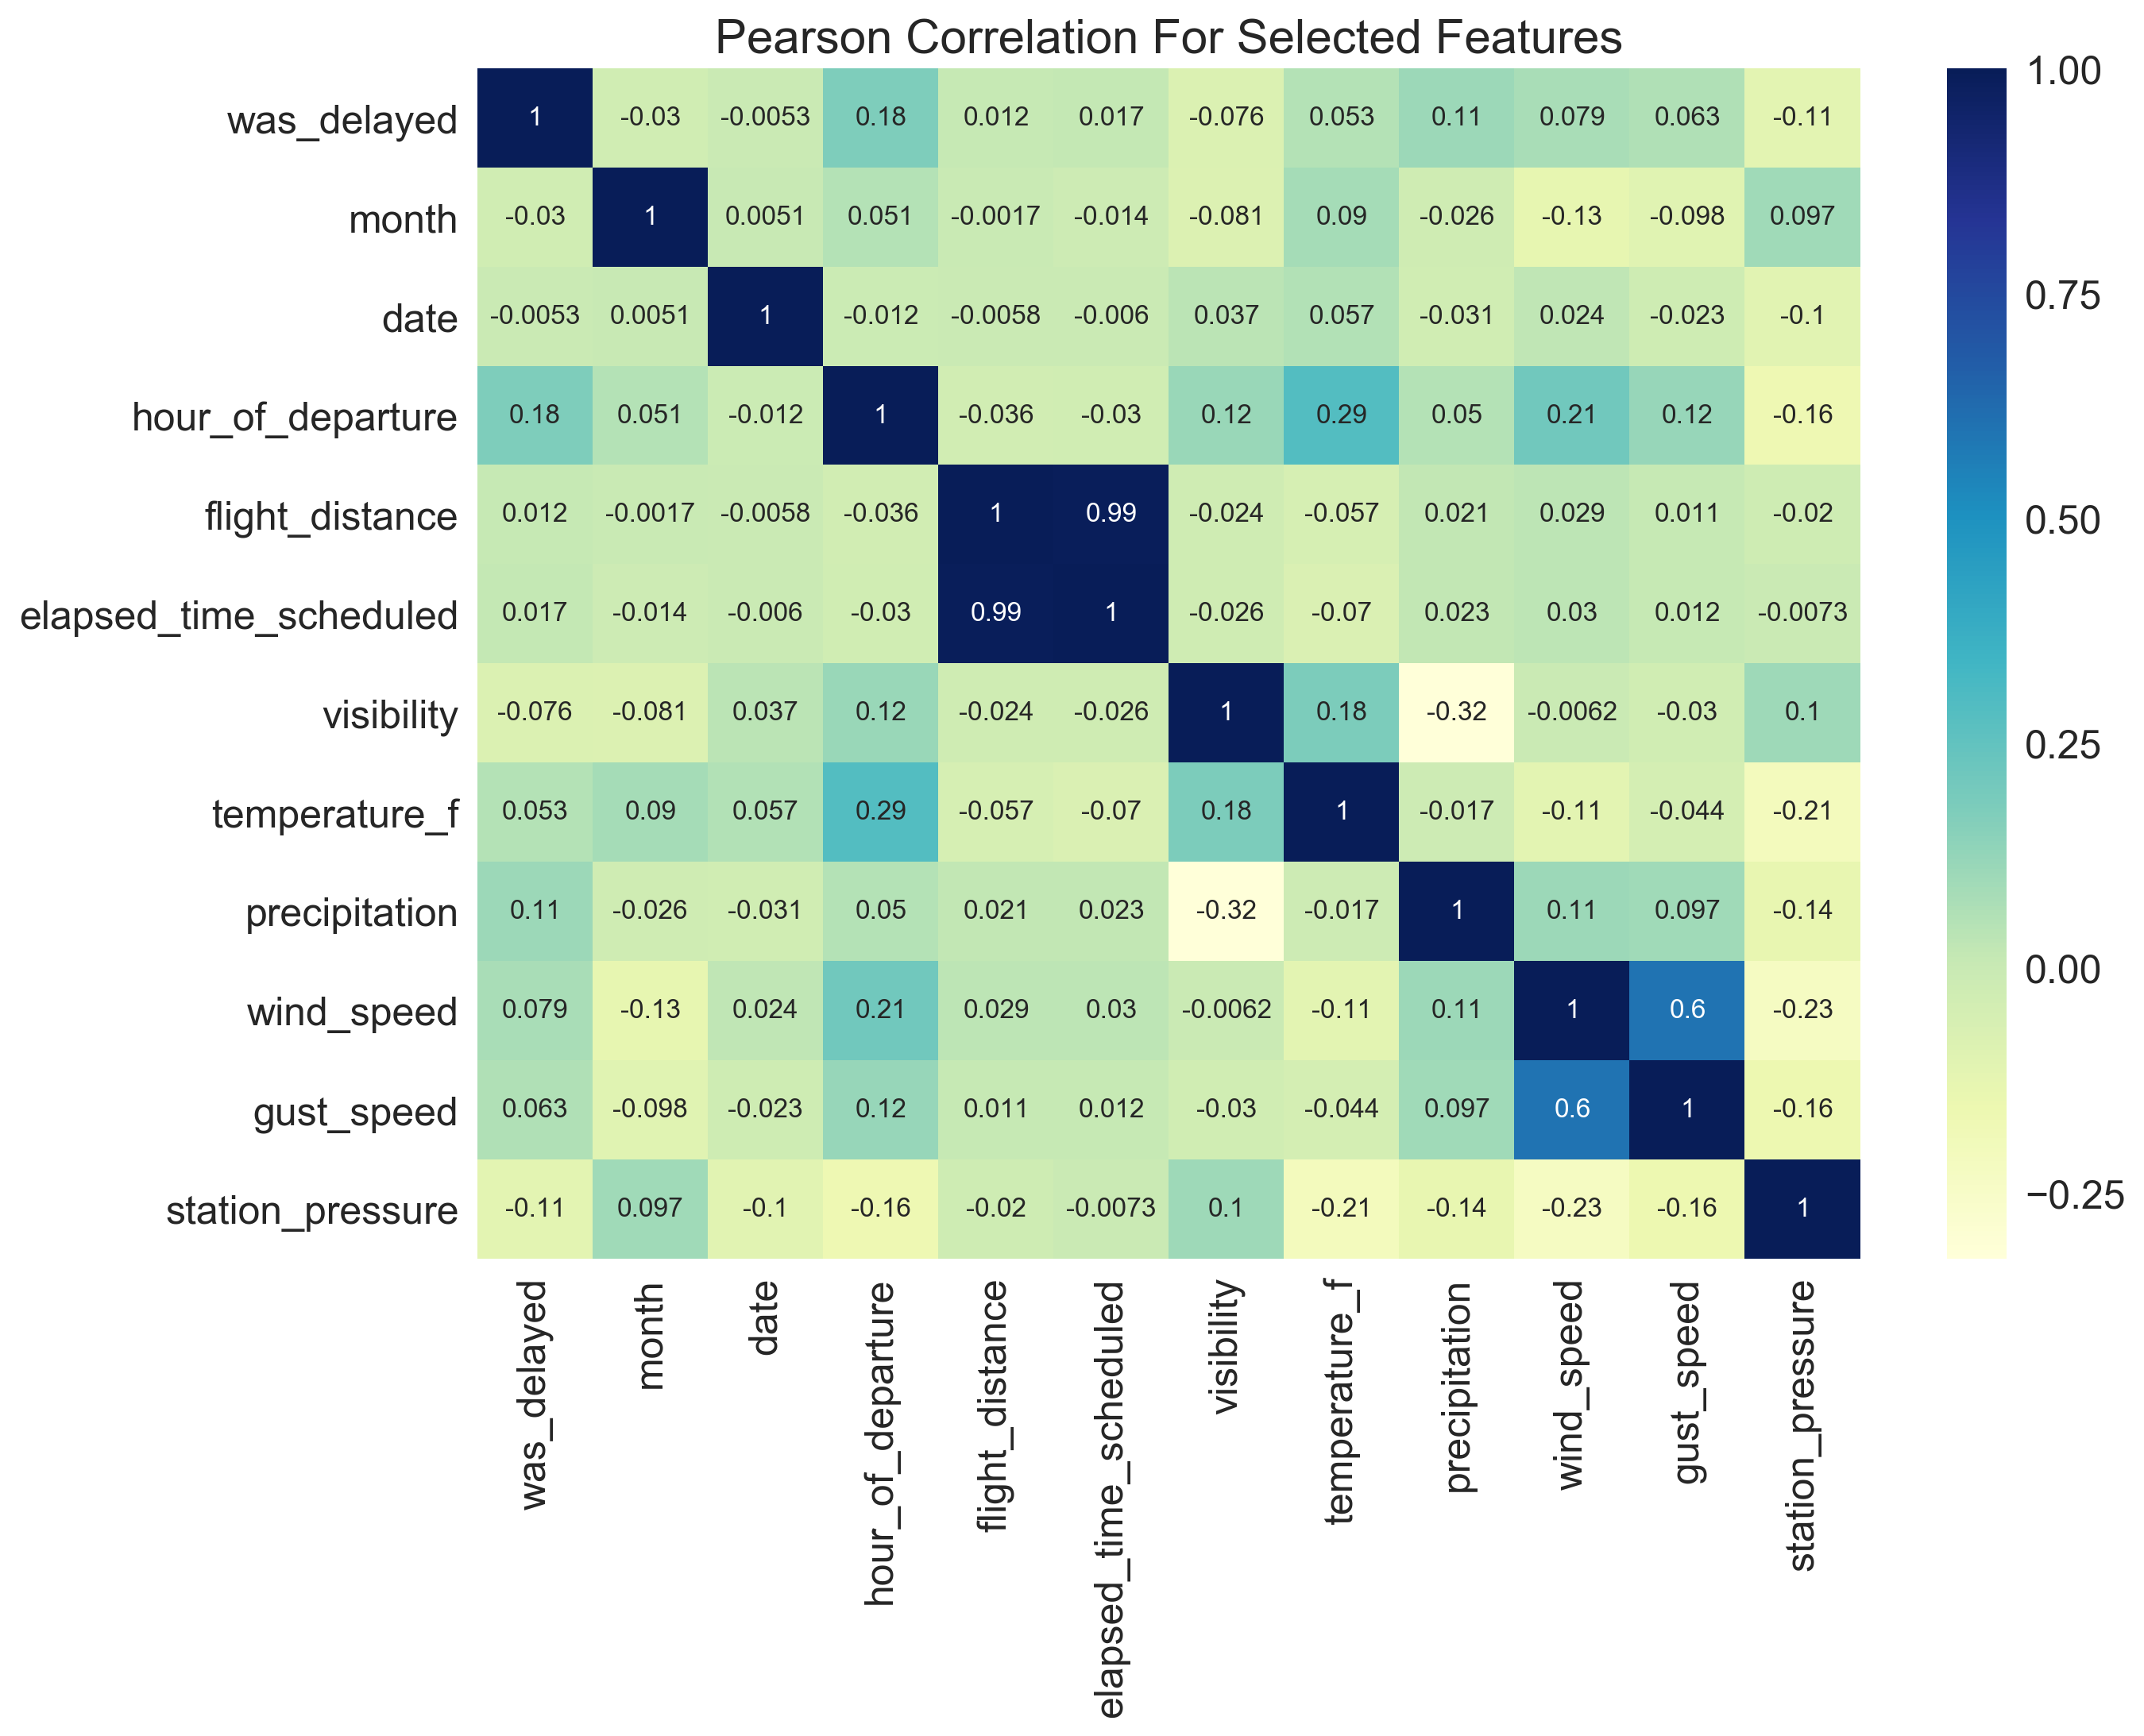

In [3]:
def plot_correlation_heatmap(correlation_matrix, save_image=False):
    fig, ax = plt.subplots(figsize=(11.7, 8.27), dpi=240)

    plt.title("Pearson Correlation For Selected Features")
    sns.heatmap(correlation_matrix, ax=ax, annot=True,  cmap="YlGnBu")
    if save_image:
        plt.savefig("../../reports/figures/initial-feature-set-correlation.png", bbox_inches='tight')
    plt.show()
    
plot_correlation_heatmap(features.corr(), save_image=True)

There High levels of correlation between elapsed time and flight distance (i.e. a flight that travels further will be in the air longer.)

In [4]:
y = features['was_delayed']
X = features.drop(['was_delayed', 'flight_distance'], axis=1)

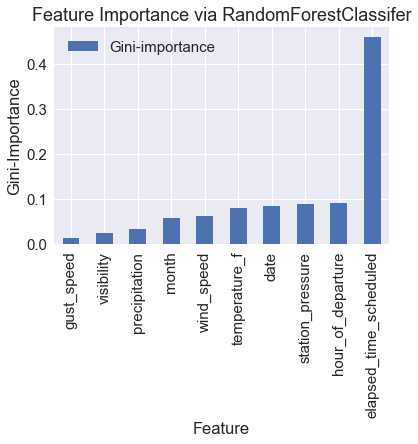

In [5]:
## generate a plot of gini importances with and without balance classes, showing that even that one small change can have an impact on what is important

from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd

def estimate_feature_importances(X, y, feature_names, class_weight=None):
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0, class_weight=class_weight)
    forest.fit(X, y)
    
    features = {}
    for feature, importance in zip(feature_names, forest.feature_importances_):
        features[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(features, orient='index').rename(columns={0: 'Gini-importance'})
    
    importances.sort_values(by='Gini-importance').plot(kind='bar')
    plt.xlabel('Feature')
    plt.ylabel('Gini-Importance')
    plt.title('Feature Importance via RandomForestClassifer')
    plt.show()
    return importances

importances = estimate_feature_importances(X=X, y=y, feature_names=X.columns)

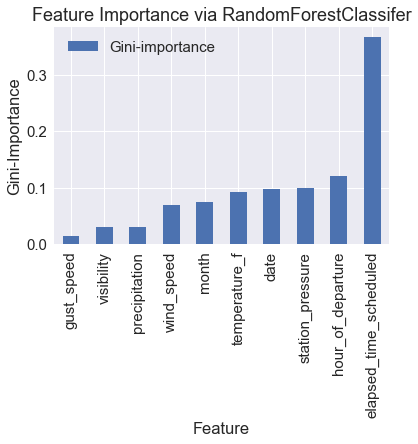

In [6]:
importances = estimate_feature_importances(X=X, y=y, feature_names=X.columns, class_weight='balanced')

In [7]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

def evaluate_pipeline(X, y, param_grid, pipeline, scoring='accuracy', random_state=12):
    """ Conduct a GridSearchCV with supplied pipeline and parameters, use reserved data for output metrics"""
    
    # Reserve a portion of the data, to reduce overfitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    
    # Initiate GridSearchCV, with 5-fold cross validtation schema, using selected scoring method
    grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring=scoring)
   
    # Fit the Grid to the training data
    grid.fit(X=X_train, y=y_train)
    
    # Inspect the output of the gridsearch
    print("   Scoring Methodology:", scoring)
    print("            Best Score:", grid.best_score_)
    print("        Best Estimator:")
    print(grid.best_estimator_)
    
    # Use the fitted grid to predict on the test data
    y_pred = grid.predict(X_test)
    print("----------------- Test Set Results -----------------")
    print("              Accuracy:", accuracy_score(y_pred=y_pred, y_true=y_test))
    print(" Classification Report:\n", classification_report(y_pred=y_pred, y_true=y_test))
    
    # Return the fitted grid for use, inspection, and storage
    return grid

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest()),
    ('approximate', None),
    ('classify', None)
])

In [9]:
from sklearn.neighbors import KNeighborsClassifier   

knn_parameters = [
    {
        'select__k': [2, 4, 10, 'all'],
        'classify': [KNeighborsClassifier()],
        'classify__weights': ['uniform', 'distance'],
        'classify__algorithm': ['auto'],
        'classify__n_neighbors': [3, 4, 5],
        'classify__n_jobs': [4]
    }
]

grid = evaluate_pipeline(X, y, knn_parameters, pipeline, scoring='precision')

   Scoring Methodology: precision
            Best Score: 0.5746461837766262
        Best Estimator:
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=10, score_func=<function f_classif at 0x113d956a8>)), ('approximate', None), ('classify', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=4, p=2,
           weights='uniform'))])
----------------- Test Set Results -----------------
              Accuracy: 0.8288138899726882
 Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.97      0.90      8417
          1       0.56      0.19      0.29      1835

avg / total       0.80      0.83      0.79     10252



In [10]:
from sklearn.svm import SVC

svc_parameters = [
    {
        'select__k': [10, 'all'],
        'classify': [SVC()],
        'classify__class_weight': ['balanced'],
        'classify__kernel': ['linear', 'rbf'],
        'classify__gamma': ['auto'],
        'classify__C': [0.1, 1.0]
    }
]

grid = evaluate_pipeline(X, y, svc_parameters, pipeline, scoring='precision')

   Scoring Methodology: precision
            Best Score: 0.2927002708103817
        Best Estimator:
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=10, score_func=<function f_classif at 0x113d956a8>)), ('approximate', None), ('classify', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
----------------- Test Set Results -----------------
              Accuracy: 0.6700156067108857
 Classification Report:
              precision    recall  f1-score   support

          0       0.90      0.67      0.77      8417
          1       0.31      0.66      0.42      1835

avg / total       0.79      0.67      0.71     10252



In [11]:
from sklearn.ensemble import RandomForestClassifier

random_forest_parameters = [
    {
        'select__k': [2,4,8,'all'],
        'classify': [RandomForestClassifier()],
        'classify__class_weight': ['balanced', 'balanced_subsample', None],
        'classify__criterion': ['gini', 'entropy'],
        'classify__max_features': ['auto', 'log2'],
        'classify__max_depth': [2, 10, 15, None],
        'classify__n_jobs': [4]
    }
]

grid = evaluate_pipeline(X, y, random_forest_parameters, pipeline, scoring='precision')

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bcbeidel/anaconda3/lib/python3.6/

   Scoring Methodology: precision
            Best Score: 0.6948407319171559
        Best Estimator:
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k='all', score_func=<function f_classif at 0x113d956a8>)), ('approximate', None), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, m...n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
----------------- Test Set Results -----------------
              Accuracy: 0.8355442840421381
 Classification Report:
              precision    recall  f1-score   support

          0       0.84      0.99      0.91      8417
          1       0.74      0.12      0.21      1835

avg / total       0.82      0.84      0.78     10252



In [12]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

kernel_approximation_parameters = [
    {
        'approximate': [RBFSampler()],
        'approximate__gamma': [0.1, 1, 10],
        'approximate__n_components': [100],
        'classify': [SGDClassifier()],
        'classify__max_iter': [5],
        'classify__class_weight': ['balanced'],
        'classify__n_jobs': [4]
    }
]

grid = evaluate_pipeline(X, y, kernel_approximation_parameters, pipeline, scoring='precision')

   Scoring Methodology: precision
            Best Score: 0.23601084531578229
        Best Estimator:
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=10, score_func=<function f_classif at 0x113d956a8>)), ('approximate', RBFSampler(gamma=0.1, n_components=100, random_state=None)), ('classify', SGDClassifier(alpha=0.0001, average=False, class_weight...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])
----------------- Test Set Results -----------------
              Accuracy: 0.6864026531408506
 Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.72      0.79      8417
          1       0.30      0.55      0.39      1835

avg / total       0.77      0.69      0.72     10252

